In [10]:
import s3fs
s3 = s3fs.S3FileSystem()
import glob

In [11]:
fname='s3://eso-west2-shared/GPM/KuPR/2A-CS-CONUS.GPM.DPR.V9-20211125.20190707-S165327-E165549.030429.V07A.HDF5'
fs=s3.glob('s3://eso-west2-shared/GPM/KuPR/2A-CS*')
fs=sorted(fs)
print(fs[0])
#import netCDF4
#with s3.open(fname, 'rb') as f:
#    nc = netCDF4.Dataset(f)

eso-west2-shared/GPM/KuPR/2A-CS-CONUS.GPM.DPR.V9-20211125.20190501-S011631-E012509.029377.V07A.HDF5


In [12]:
import io
from urllib.parse import urlparse
import boto3
import h5py
import fsspec

In [45]:
import numpy as np
def readOrb(h5f):
    fh=h5f
    sfcPrecip=fh['FS/SLV/precipRateNearSurface'][:,:]
    precipRate=fh['FS/SLV/precipRate'][:,:]
    piaFinal=fh['FS/SLV/piaFinal'][:,:]
    lon=fh['FS/Longitude'][:,:]
    lat=fh['FS/Latitude'][:,:]
    hzero=fh['FS/VER/heightZeroDeg'][:,:]
    pType=fh['FS/CSF/typePrecip'][:,:]
    stormTop=fh['FS/PRE/heightStormTop'][:,:]
    pType=(pType/1e7).astype(np.int16)
    bzd=fh['FS/VER/binZeroDeg'][:,:]
    zku=fh['FS/PRE/zFactorMeasured'][:,:,:,0]
    zka=fh['FS/PRE/zFactorMeasured'][:,:,:,1]
    bcf=fh['FS/PRE/binClutterFreeBottom'][:,:]
    bsfc=fh['FS/PRE/binRealSurface'][:,:]
    return sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,fh,piaFinal,bsfc

In [ ]:
import time

import xarray
npatches=0
it=0
for f in fs[0:100]:
    zKuL=[]
    zKaL=[]
    hzeroL=[]
    pTypeL=[]
    stormTopL=[]
    bzdL=[]
    bcfL=[]
    piaFinalL=[]
    sfcPrecipML=[]
    bsfcL=[]
    fname="s3://"+f
    s3f = fsspec.open(fname, mode='rb', default_fill_cache=False)
    h5f = h5py.File(s3f.open(), mode='r')
    t1=time.time()
    sfcPrecip,hzero,pType,stormTop,bzd,zku,zka,bcf,precipRate,fh,piaFinal,bsfc=readOrb(h5f)
    t2=time.time()
    nx=sfcPrecip.shape[0]
    for i in range(6,nx-6):
        for j in range(12,37):
            sfcPrecipM=sfcPrecip[i-5:i+6,j-5:j+5].mean()
            if sfcPrecipM>=0:
                if sfcPrecipM>0.05 :
                    zKuL.append(zku[i-5:i+5,j-5:j+5,:])
                    zKaL.append(zka[i-5:i+5,j-5:j+5,:])
                    hzeroL.append(hzero[i-5:i+5,j-5:j+5])
                    pTypeL.append(pType[i-5:i+5,j-5:j+5])
                    stormTopL.append(stormTop[i-5:i+5,j-5:j+5])
                    bzdL.append(bzd[i-5:i+5,j-5:j+5])
                    bcfL.append(bcf[i-5:i+5,j-5:j+5])
                    piaFinalL.append(piaFinal[i-5:i+5,j-5:j+5,:])
                    sfcPrecipML.append(sfcPrecipM)
                    bsfcL.append(bsfc[i-5:i+5,j-5:j+5,0])
    npatches+=len(bsfcL)  
    if len(zKuL)==0:
        continue
    zKu_=xr.DataArray(np.array(zKuL),dims=['time','ni','nj','nr'])
    zKa_=xr.DataArray(np.array(zKaL),dims=['time','ni','nj','nr'])
    hzero_=xr.DataArray(np.array(hzeroL),dims=['time','ni','nj'])
    pType_=xr.DataArray(np.array(pTypeL),dims=['time','ni','nj'])
    stormTop_=xr.DataArray(np.array(stormTopL),dims=['time','ni','nj'])
    bzd_=xr.DataArray(np.array(bzdL),dims=['time','ni','nj'])
    bcf_=xr.DataArray(np.array(bcfL),dims=['time','ni','nj'])
    piaFinal_=xr.DataArray(np.array(piaFinalL),dims=['time','ni','nj','n2'])
    bsfc_=xr.DataArray(np.array(bsfcL),dims=['time','ni','nj'])
    sfcPrecip_=xr.DataArray(np.array(sfcPrecipML),dims=['time'])
    orbit=f.split('.')[-3]
    datetime=f.split('.')[-4]
    outputf='data/obs50kmx50_%s_%s_km.nc'%(datetime,orbit)
    ds=xr.Dataset({'zKu':zKu_,'zKa':zKa_,'hzero':hzero_,'pType':pType_,'stormTop':stormTop_,'bzd':bzd_,'bcf':bcf_,\
                   'piaFinal':piaFinal_,'bsfc':bsfc_,'sfcPrecip':sfcPrecip_})
    ds.to_netcdf(outputf,encoding={'zKu':{'zlib':True,'complevel':5},'zKa':{'zlib':True,'complevel':5},\
                                   'hzero':{'zlib':True,'complevel':5},'pType':{'zlib':True,'complevel':5},\
                                   'stormTop':{'zlib':True,'complevel':5},'bzd':{'zlib':True,'complevel':5},\
                                   'bcf':{'zlib':True,'complevel':5}})
    if it%5==0:
        print('I/O time=',t2-t1)
        print("npatches=",npatches)
    it+=1
    

I/O time= 22.09665298461914
npatches= 2438
I/O time= 21.097234964370728
npatches= 11569
I/O time= 21.803064584732056
npatches= 19339
I/O time= 21.454176664352417
npatches= 29081


<HDF5 dataset "binRealSurface": shape (741, 49, 2), type "<i2">
eso-west2-shared/GPM/KuPR/2A-CS-CONUS.GPM.DPR.V9-20211125.20190502-S233353-E234231.029407.V07A.HDF5
obs50kmx50_20190502-S233353-E234231_029407_km.nc
upload: data/obs50kmx50_20190502-S233353-E234231_029407_km.nc to s3://eso-west2-shared/GPM/KuPR/data/obs50kmx50_20190502-S233353-E234231_029407_km.nc


0

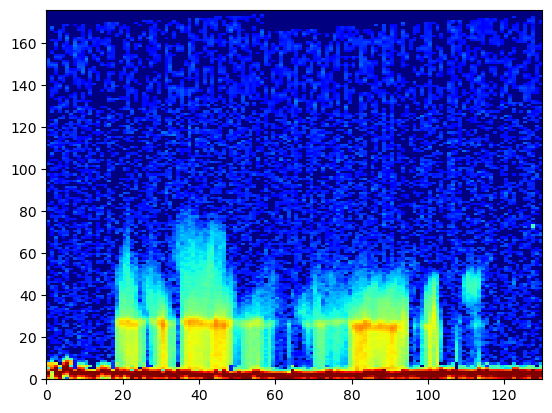

In [59]:
import matplotlib.pyplot as plt
plt.pcolormesh(zku[350:480,24,::-1].T,cmap='jet',vmin=0,vmax=60)
print(h5f['FS/PRE/binRealSurface'])
print(f)
orbit=f.split('.')[-3]
datetime=f.split('.')[-4]
outputf='obs50kmx50_%s_%s_km.nc'%(datetime,orbit)
print(outputf)
ds.to_netcdf('data/'+outputf,encoding={'zKu':{'zlib':True,'complevel':5},'zKa':{'zlib':True,'complevel':5},\
                                   'hzero':{'zlib':True,'complevel':5},'pType':{'zlib':True,'complevel':5},\
                                   'stormTop':{'zlib':True,'complevel':5},'bzd':{'zlib':True,'complevel':5},\
                                   'bcf':{'zlib':True,'complevel':5}})
cmd='aws s3 cp data/%s s3://eso-west2-shared/GPM/KuPR/data/%s'%(outputf,outputf)
import os
os.system(cmd)

In [63]:
print(len(zKuL))

0


539


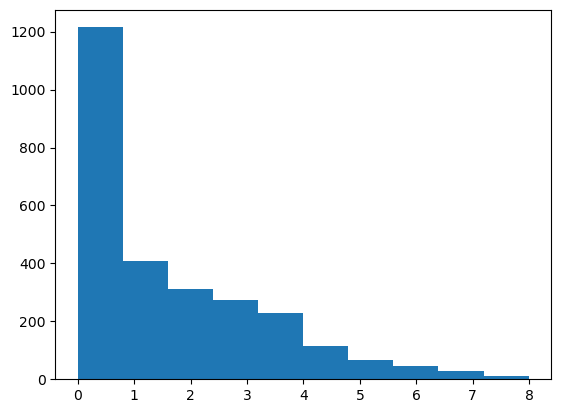

In [38]:
sfcPrecip50=[]


                
sfcPrecip50=np.array(sfcPrecip50)
plt.hist(sfcPrecip50)
a=np.nonzero(np.abs(sfcPrecip50-1)<0.5)
print(len(a[0]))

In [28]:
print(h5f['FS'].keys())

<KeysViewHDF5 ['ScanTime', 'scanStatus', 'navigation', 'PRE', 'VER', 'CSF', 'SRT', 'DSD', 'Experimental', 'SLV', 'FLG', 'TRG', 'Latitude', 'Longitude', 'sunLocalTime']>


In [40]:
import xarray as xr


print(hzero_.shape)
print(pType_.shape)
print(stormTop_.shape)
print(hzero.shape)
print(piaFinal.shape)
ds=xr.Dataset({'zKu':zKu_,'zKa':zKa_,'hzero':hzero_,'pType':pType_,'stormTop':stormTop_,'bzd':bzd_,'bcf':bcf_,'piaFinal':piaFinal_})
ds.to_netcdf('obs50kmx50km.nc')


(539, 10, 10)
(539, 10, 10)
(539, 10, 10)
(741, 49)
(741, 49, 2)
